In [1]:
from fastai.text import *
from inltk.inltk import get_similar_sentences, tokenize
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb
from tqdm import tqdm

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.1.0')

In [3]:
torch.cuda.set_device(0)

In [4]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [5]:
random_seed(1,True)

In [6]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-hindi/classification-movie-review


In [7]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-hindi/classification-movie-review')

In [8]:
df_train = pd.read_csv(path/'train.csv')
df_train.head()

,text,experience
0,चंद्रमोहन शर्मा को-प्रड्यूसर और लीड ऐक्टर अक्ष...,2
1,अगर आप इस फिल्म को देखने जा रहे हैं तो सबसे पह...,0
2,बॉलीवुड वाले चोरी-छिपे हॉलीवुड फिल्मों से कहान...,2
3,"बैनर :\nसंजय दत्त प्रोडक्शन्स प्रा.लि., रुपाली...",0
4,1959 में घटित चर्चित नानावटी कांड में एक क्राइ...,1


In [9]:
df_train_aug = pd.read_csv(path/'train_aug.csv')
df_train_aug.head()

,text,experience
0,चन्द्रमोहन शर्मा का-प्रड्यूसर और डालीड ऐक्टर ल...,2
1,यदि आप इस फिल्म को जानने जा रहे हैं तो सबसे पह...,0
2,हॉलीवुडवाले चोरी-छिपे हॉलीवुड फ़िल्में से कहान...,2
3,"जूरी: सोनिया दत्त प्रोडक्शन्स प्रा.लि., रुपाली...",0
4,1959 में घटित चर्चित चौरासीवटी कांडमें एक क्रा...,1


In [10]:
df_valid = pd.read_csv(path/'valid.csv')
df_valid.head()

,text,experience
0,"\n\nबैनर :\nनेक्स्ट जेन फिल्म्स प्रोडक्शन्स, इ...",2
1,इस शुक्रवार रिलीज हुई इकलौती इस हॉलिवुड मूवी क...,2
2,"\n\nबैनर :\nयूटीवी मोशन पिक्चर्स, टिप्स म्युजि...",1
3,"चंद्रमोहन शर्मा, नवभारत टाइम्स पिछले कुछ अर्से...",0
4,\n\nशनाया ग्रोवर (मंजरी फडणीस) पर हत्या का आरो...,0


In [11]:
df_train.shape, df_valid.shape

((718, 2), (180, 2))

In [12]:
for df in [df_train, df_valid]:
    if len(df) == 718:
        print('In Training Set:')
    else:
        print('In Valid Set:')
    print('Positive Examples', (df['experience'] == 2).sum())
    print('Neutral Examples', (df['experience'] == 1).sum())
    print('Negative Examples', (df['experience'] == 0).sum())
    print('\n\n\n')

In Training Set:
Positive Examples 273
Neutral Examples 205
Negative Examples 240




In Valid Set:
Positive Examples 62
Neutral Examples 65
Negative Examples 53






In [13]:
df_train['text'][0]

'चंद्रमोहन शर्मा को-प्रड्यूसर और लीड ऐक्टर अक्षय कुमार की मानें तो उनकी नई फिल्म एयरलिफ्ट की कहानी और किरदार बिल्कुल सच्चे हैं। पहले खाड़ी युद्ध को कवर करने वाले एक सीनियर रिपोर्टर और उस वक्त एयर इंडिया में उच्च पद पर रहे एक अफसर इस कहानी को सच से परे मानते हैं। हालांकि, स्क्रीन पर आप जो कुछ भी देखेंगे वह सब सच के बेहद करीब है। बॉलिवुड की खबरें अपने फेसबुक पर पाना हो तो लाइक करें Nbt Movies फिल्म की कहानी चार अहम किरदारों के इर्द-गिर्द घूमती है। इन चारों को मिलाकर एक लीड किरदार स्क्रीन पर उतारा गया है, जिसे अक्षय कुमार ने निभाया है। यह फिल्म पहले खाड़ी युद्ध पर आधारित है। इस जंग के दौरान कुवैत में फंसे करीब एक लाख सत्तर हजार भारतीय नागरिकों को देश वापस लाए जाने की घटना को डायरेक्टर ने अपने अंदाज से पेश किया है। किरदारों को पर्दे पर उतारने में कुछ फिल्मी आजादी की जरूरत होती है, यही आजादी फिल्म के डायरेक्टर राजा मेनन ने भी ली है। देखिए, फिल्म का ट्रेलर  इस घटना को और ज्यादा असरदार ढंग से पेश करने के मकसद से राजा ने फिल्म के कुछ सीन्स को दुबई से करीब चार घंटे की दूरी पर स्थित रसेल खेमा मे

In [14]:
df_train_aug['text'][0]

'चन्द्रमोहन शर्मा का-प्रड्यूसर और डालीड ऐक्टर लल्लू कुमार की कहेंगे अतः उनकी नई फिल्मों एयरलिफ्ट का कहानी और भुमिका बिल्कुल सच्चे हैँ।" पहिले खाड़ी युद्घ को कवर करने वाले अपने सीनियर रिपोर्टर व उस वक्तएयर इंडिया में उच्च रातों को रहे एक सैनिको इसी कहानी का सचपूर्वक परे मानता हैँ। हालांकि, स्क्रीन पर आप जो कुछ भी ईलाज वो समस्त सच की अत्यन्तद करीब है। बॉलिवुड की खबरऐं अपने फेसबुक पर दिखाना हो तो गन्स करें Nbug Muralies फिल्म की कथानक चार अहम किरदारओं के तारतम्य–गिर्द घूमती है। इस बायीं का मिलाने एक लीड किरदार स्क्रीन पर उतारा गया हे, जिन्हें अक्षय कुमार ने निभाया हे। ये फिल्म पहिले खाड़ी युद्ध पर आधारित है। इस जंग की दौरान शारजाहमें फंसे क़रीब एक करोड़ सत्तर हजार भारतीय नागरिकों को देश वापस लाते जाने की घटना को डायरेक्टर ने अपने मानदण्डपूर्वक पेश करवाया हे। किरदारों को पर्दे पर उतारने में अधिकांश फिल्मी आजादी का जरूरत होती है, यही ग़दर फिल्म के डायरेक्टर राजा मेनन द्वारा भी डाली है। देखिए, फिल्म का ट्रेलर इसी घटनाओं का और बेहतर असरदार ढंगपूर्वक क्रियान्वित करने के सामजत्थेपूर्वक राजा ने 

In [15]:
df_train = pd.concat([df_train,df_train_aug])
df_train.shape

(1436, 2)

In [16]:
df_train[df_train['text'].isnull()].shape

(0, 2)

In [17]:
df_valid[df_valid['text'].isnull()].shape

(0, 2)

In [18]:
label_cols = list(range(1,df_train.shape[1]))

In [19]:
print(label_cols)

[1]


In [20]:
id_to_col = list(df.columns)

In [21]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [22]:
class HindiTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/'../tokenizer/hindi_lm_large.model'))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [23]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/'../tokenizer/hindi_lm_large.model'))
itos = [sp.IdToPiece(int(i)) for i in range(30000)]

In [24]:
itos[:10]

['<unk>', '<s>', '</s>', '▁के', '।', '▁में', '▁है', ',', '▁की', '▁']

In [25]:
# 30,000 is the vocab size that we chose in sentencepiece
hindi_vocab = Vocab(itos)

In [26]:
tokenizer = Tokenizer(tok_func=HindiTokenizer, lang='hi')

In [27]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [28]:
random_seed(1, True)
data_lm = TextLMDataBunch.from_df(path=path, train_df=df_train, valid_df=df_valid, text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=hindi_vocab, bs=16, num_workers=0)

In [29]:
data_lm.show_batch()

idx,text
0,"▁स्क्रीन ▁पर ▁आप ▁जो ▁कुछ ▁भी ▁देखेंगे ▁वह ▁सब ▁सच ▁के ▁बेहद ▁करीब ▁है । ▁बॉल ि वुड ▁की ▁खबरें ▁अपने ▁फेसबुक ▁पर ▁पाना ▁हो ▁तो ▁लाइक ▁करें <unk> ▁n b t <unk> ▁m ov ies ▁फिल्म ▁की ▁कहानी ▁चार ▁अहम ▁किरदार ों ▁के ▁इर्द - गिर्द ▁घूमती ▁है । ▁इन ▁चारों ▁को ▁मिलाकर ▁एक ▁लीड ▁किरदार ▁स्क्रीन ▁पर ▁उतारा ▁गया ▁है , ▁जिसे ▁अक्षय ▁कुमार ▁ने ▁निभाया ▁है ।"
1,▁करने ▁और ▁अपनी ▁पहचान ▁साबित ▁करने ▁के ▁लिए ▁रेसलिंग ▁की ▁दुनिया ▁में ▁लौट ता ▁है । ▁ऐक्ट िंग ▁: ▁स्टार्ट ▁टू ▁लास्ट ▁तक ▁फिल्म ▁सलमान ▁खान ▁के ▁मजबूत ▁कंधों ▁पर ▁टिकी ▁है । ▁रेवाड़ी ▁के ▁एक ▁छोटे ▁से ▁गांव ▁में ▁रहने ▁वाले ▁हरियाणवी ▁पहलवान ▁के ▁इस ▁किरदार ▁में ▁सलमान ▁ने ▁अपने ▁बेहतरीन ▁अभिनय ▁से ▁जान ▁डाल ▁दी ▁है । ▁देसी ▁पहलवान ▁से ▁विदेशी ▁रेस लर ▁के ▁किरदार ▁को ▁निभाने ▁के
2,ाय ▁अपनी ▁बेटी ▁का ▁नाम ▁गौर ा ▁रखता ▁है ▁और ▁कहता ▁है ▁कि ▁उसकी ▁मां ▁की ▁मृत्यु ▁हो ▁गई ▁है । ▁गौर ा ▁गू ंगी ▁है । ▁आठ ▁वर्ष ▁की ▁होने ▁पर ▁गौर ा ▁को ▁पता ▁चल ▁जाता ▁है ▁कि ▁उसकी ▁मां ▁जीवित ▁है । ▁वह ▁मां ▁से ▁मिलने ▁की ▁जि द ▁करती ▁है । ▁आखिरकार ▁शिव ाय ▁उसे ▁लेकर ▁बुल्गारिया ▁जाता ▁है । ▁दोनों ▁ओल ्गा ▁को ▁ढूंढ ते
3,"▁है ▁और ▁चाइल्ड ▁सेक्स ▁के ▁अवैध ▁व्यापार ▁का ▁भारत ▁बड़ा ▁केन्द्र ▁माना ▁जाता ▁है । ▁ज्यादातर ▁गरीब ▁और ▁अशिक्षित ▁लोगों ▁की ▁बालिका ओं ▁को ▁उठा ▁लिया ▁जाता ▁है ▁और ▁तथाकथित ▁स भ्रांत ▁और ▁शक्तिशाली ▁लोग ▁इनका ▁शोषण ▁करते ▁हैं । ▁इन ▁बातों ▁को ▁लेकर ▁फिल्म ▁निर्देशक ▁प्रदीप ▁सरकार ▁ने ▁' म र्दा नी ' ▁बनाई ▁है । ▁सरकार ▁कमर्शियल ▁फॉर्मेट ▁में ▁फिल्म ▁बनाते ▁हैं , ▁लेकिन ▁सामाजिक ▁मुद्दे ▁से ▁उसे"
4,"्टे ▁जरूर ▁लगे , ▁लेकिन ▁ दह शत ▁पैदा ▁नहीं ▁कर ▁पाए । ▁उनके ▁बोले ▁गए ▁संवाद ▁अस्पष्ट ▁हैं । ▁कुल ▁मिलाकर ▁सुपरहीरो ▁' फ्ल ा इंग ▁ज ट्ट ' ▁निराश ▁करता ▁है । ▁बैनर ▁: ▁बालाजी ▁मोशन ▁पिक्चर्स ▁निर्माता ▁: ▁एकता ▁कपूर , ▁शोभा ▁कपूर ▁निर्देशक ▁: ▁रे मो ▁डि सू जा ▁संगीत ▁: ▁सचिन - जि गर ▁कलाकार ▁: ▁टाइगर ▁श्रॉफ , ▁जैक लीन ▁फर्नांड ीस , ▁"


In [30]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3, pretrained=False)

In [31]:
path

PosixPath('/home/gaurav/PycharmProjects/nlp-for-hindi/classification-movie-review')

In [32]:
# Loading the pretrained language model on hindi wikipedia
learn.load(path/'../language-model/HindiDataset/ulmfit_large/models/model', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (1436 items)
x: LMTextList
▁x x bo s ▁चंद्र मोहन ▁शर्मा ▁को - प्र ड्यू सर ▁और ▁लीड ▁ऐक्ट र ▁अक्षय ▁कुमार ▁की ▁माने ं ▁तो ▁उनकी ▁नई ▁फिल्म ▁एयर लि फ्ट ▁की ▁कहानी ▁और ▁किरदार ▁बिल्कुल ▁सच्चे ▁हैं । ▁पहले ▁खाड़ी ▁युद्ध ▁को ▁कवर ▁करने ▁वाले ▁एक ▁सीनियर ▁रिपोर्ट र ▁और ▁उस ▁वक्त ▁एयर ▁इंडिया ▁में ▁उच्च ▁पद ▁पर ▁रहे ▁एक ▁अफसर ▁इस ▁कहानी ▁को ▁सच ▁से ▁परे ▁मानते ▁हैं । ▁हालांकि , ▁स्क्रीन ▁पर ▁आप ▁जो ▁कुछ ▁भी ▁देखेंगे ▁वह ▁सब ▁सच ▁के ▁बेहद ▁करीब ▁है । ▁बॉल ि वुड ▁की ▁खबरें ▁अपने ▁फेसबुक ▁पर ▁पाना ▁हो ▁तो ▁लाइक ▁करें <unk> ▁n b t <unk> ▁m ov ies ▁फिल्म ▁की ▁कहानी ▁चार ▁अहम ▁किरदार ों ▁के ▁इर्द - गिर्द ▁घूमती ▁है । ▁इन ▁चारों ▁को ▁मिलाकर ▁एक ▁लीड ▁किरदार ▁स्क्रीन ▁पर ▁उतारा ▁गया ▁है , ▁जिसे ▁अक्षय ▁कुमार ▁ने ▁निभाया ▁है । ▁यह ▁फिल्म ▁पहले ▁खाड़ी ▁युद्ध ▁पर ▁आधारित ▁है । ▁इस ▁जंग ▁के ▁दौरान ▁कुवैत ▁में ▁फंसे ▁करीब ▁एक ▁लाख ▁सत्तर ▁हजार ▁भारतीय ▁नागरिकों ▁को ▁देश ▁वापस ▁लाए ▁जाने ▁की ▁घटना ▁को ▁डायरेक्टर ▁ने ▁अपने ▁अंदाज ▁से ▁पेश ▁किया ▁है । ▁

In [33]:
# Fine tuning the prtrained LM on current dataset

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


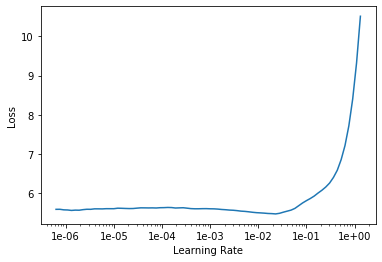

In [35]:
learn.recorder.plot()

In [36]:
learn.freeze()

In [37]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.488463,3.939221,0.341214,01:30


In [38]:
learn.save('fit_head', with_opt=True)

In [39]:
learn.load('fit_head', with_opt=True);

In [40]:
learn.unfreeze()

In [41]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.813974,3.711267,0.370426,01:39


In [42]:
learn.save('fine_tuned', with_opt=True)

In [43]:
learn.load('fine_tuned', with_opt=True);

In [44]:
learn.predict('जिसके लिये उन्हें',n_words=10)

'जिसके लिये उन्हें ▁जानी ▁चाहिए ▁है ▁वह ▁साम ्ज़ म स्ती ▁में ▁विश्वास'

In [45]:
learn.save_encoder('fine_tuned_enc')

In [46]:
random_seed(1, True)
data_clas = TextClasDataBunch.from_df(path=path, train_df=df_train, valid_df=df_valid, tokenizer=tokenizer, vocab=hindi_vocab, text_cols=[0], label_cols=label_cols, bs=16, num_workers=0)

In [47]:
data_clas.show_batch()

text,target
"▁x x bo s ▁राजकुमार ▁ही तोली ▁जैसे ▁चौड़े ▁कद ▁के ▁निर्देशक ▁के ▁लिए ▁संजय ▁दत्त ▁जैसा ▁बारे ▁स्तरों पूर्वक ▁नीचे ▁है । ▁तदनंतर ▁संजय ▁दत्त ▁के ▁जीवन ▁में ▁ऐसे ▁क्या ▁हे ▁कि ▁ही रानी ▁को ▁उस ▁पर ▁फिल्म ▁बनाने ▁की ▁जरूरत ▁महसूस ▁बन ।"" ▁नि ▁:- विवेक ▁सोनिया ▁की ▁जीवन में ▁विभिन्न ▁ऐसे ▁घसीट - बोधक ▁है ँ ▁जिस ▁पर ▁कमर्शियल ▁फिल्म ▁बनाई ▁जा ▁सकती ▁है ▁तथा ▁लेकिन ▁ही",2
▁x x bo s ▁पाकिस्तान - नेपाल ▁के ▁खट्टे ▁- मी ठे ▁रिश्तों ▁ने ▁हमेशा ▁अत्यंत ▁फिल्म कारों ▁को ▁आकर्षित ▁किया ▁है ▁. ▁गदर ▁सहित ▁फिल्मों ▁में ▁खट्टा ▁अधिक ▁था ▁तो ▁' बिस ज रंगी ▁भाई शत्रु ' ▁में ▁इन ▁पड़ोसी ▁देशों ▁के ▁बारे ▁में ▁मिठास ▁ज्यादा ▁बैठती ▁हैं ▁. ▁गदर ▁में ▁उसकी ▁पत्नियों ▁को ▁लेने ▁के ▁लिय ▁सन ी ▁देओल ▁पाकिस्तान ▁में ▁जा ▁खड़े ▁हुए ▁और ▁पूरे ▁हुकूमत ▁को,2
▁x x bo s ▁भारत - पाकिस्तान ▁के ▁खट्टे - मी ठे ▁रिश्तों ▁ने ▁हमेशा ▁ही ▁फिल्म कारों ▁को ▁आकर्षित ▁किया ▁है । ▁गदर ▁जैसी ▁फिल्मों ▁में ▁खट्टा ▁ज्यादा ▁था ▁तो ▁' ब ज रंगी ▁भाई जान ' ▁में ▁इन ▁पड़ोसी ▁देशों ▁के ▁बारे ▁में ▁मिठास ▁ज्यादा ▁मिलती ▁है । ▁गदर ▁में ▁अपनी ▁पत्नी ▁को ▁लेने ▁के ▁लिए ▁सन ी ▁देओल ▁पाकिस्तान ▁में ▁जा ▁खड़े ▁हुए ▁और ▁पूरी ▁फौज ▁को,2
▁x x bo s ▁कई ▁बार ▁चीजें ▁इतनी ▁पर फ ेक्ट ▁हो ▁जाती ▁हैं ▁कि ▁यकीन ▁करना ▁पड़ता ▁है ▁कि ▁किसी ▁अदृश्य ▁शक्ति ▁का ▁साथ ▁था । ▁1975 ▁में ▁रिलीज ▁हुई ▁‘ शो ले ’ ▁को ▁बनाते ▁समय ▁किसी ▁ने ▁उम्मीद ▁नहीं ▁की ▁थी ▁कि ▁वे ▁सब ▁इतिहास ▁लिखने ▁जा ▁रहे ▁हैं । ▁एक ▁ऐसी ▁फिल्म ▁बनाने ▁जा ▁रहे ▁हैं ▁जिसे ▁क्ला ▁सिक ▁माना ▁जाएगा ▁या ▁मिलि ने यम ▁की,2
"▁x x bo s ▁झूला ी ▁तो ▁घसीट ियों ▁नाम ▁इस ▁फिल्म ▁पर ▁स्विमिंग ▁नहीं ▁करता । ▁थोड़ा ▁व रिश् गेर ▁या ▁सकारात्मक ▁सा ▁लगता ▁है , ▁लेकिन ▁फिल्म का ऊँगली जा ज ▁भ्रम ▁नहीं ▁है । ▁दरअसल ▁' हंस ी ▁तो ▁घसीट ी ' ▁दो ▁बेह लुस ▁हल्की - फुल्क ी ▁रोमांटिक - कॉम े डी ▁मूवी ▁है ▁जो ▁ज्यादातर ▁समय ▁दर्शकों ▁का ▁स्फूर्ति ▁कराने ▁में ▁कामयाब ▁रहती ▁है",2


In [48]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)

In [49]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1436 items)
x: TextList
▁x x bo s ▁चंद्र मोहन ▁शर्मा ▁को - प्र ड्यू सर ▁और ▁लीड ▁ऐक्ट र ▁अक्षय ▁कुमार ▁की ▁माने ं ▁तो ▁उनकी ▁नई ▁फिल्म ▁एयर लि फ्ट ▁की ▁कहानी ▁और ▁किरदार ▁बिल्कुल ▁सच्चे ▁हैं । ▁पहले ▁खाड़ी ▁युद्ध ▁को ▁कवर ▁करने ▁वाले ▁एक ▁सीनियर ▁रिपोर्ट र ▁और ▁उस ▁वक्त ▁एयर ▁इंडिया ▁में ▁उच्च ▁पद ▁पर ▁रहे ▁एक ▁अफसर ▁इस ▁कहानी ▁को ▁सच ▁से ▁परे ▁मानते ▁हैं । ▁हालांकि , ▁स्क्रीन ▁पर ▁आप ▁जो ▁कुछ ▁भी ▁देखेंगे ▁वह ▁सब ▁सच ▁के ▁बेहद ▁करीब ▁है । ▁बॉल ि वुड ▁की ▁खबरें ▁अपने ▁फेसबुक ▁पर ▁पाना ▁हो ▁तो ▁लाइक ▁करें <unk> ▁n b t <unk> ▁m ov ies ▁फिल्म ▁की ▁कहानी ▁चार ▁अहम ▁किरदार ों ▁के ▁इर्द - गिर्द ▁घूमती ▁है । ▁इन ▁चारों ▁को ▁मिलाकर ▁एक ▁लीड ▁किरदार ▁स्क्रीन ▁पर ▁उतारा ▁गया ▁है , ▁जिसे ▁अक्षय ▁कुमार ▁ने ▁निभाया ▁है । ▁यह ▁फिल्म ▁पहले ▁खाड़ी ▁युद्ध ▁पर ▁आधारित ▁है । ▁इस ▁जंग ▁के ▁दौरान ▁कुवैत ▁में ▁फंसे ▁करीब ▁एक ▁लाख ▁सत्तर ▁हजार ▁भारतीय ▁नागरिकों ▁को ▁देश ▁वापस ▁लाए ▁जाने ▁की ▁घटना ▁को ▁डायरेक्टर ▁ने ▁अपने ▁अंदाज ▁से ▁पेश ▁किया ▁है । ▁किरदा

In [50]:
learn.freeze()

In [51]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


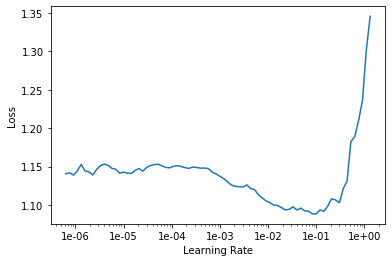

In [52]:
learn.recorder.plot()

In [53]:
learn.loss_func.func

CrossEntropyLoss()

In [54]:
kappa = KappaScore()

In [55]:
learn.metrics = [kappa, accuracy]

In [56]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.980229,0.982216,0.283234,0.522222,00:48


In [57]:
learn.save('first-full')

In [63]:
learn.load('first-full');

In [64]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.937766,0.883993,0.404467,0.600000,00:54


In [65]:
learn.save('second-full')

In [66]:
learn.load('second-full')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1436 items)
x: TextList
▁x x bo s ▁चंद्र मोहन ▁शर्मा ▁को - प्र ड्यू सर ▁और ▁लीड ▁ऐक्ट र ▁अक्षय ▁कुमार ▁की ▁माने ं ▁तो ▁उनकी ▁नई ▁फिल्म ▁एयर लि फ्ट ▁की ▁कहानी ▁और ▁किरदार ▁बिल्कुल ▁सच्चे ▁हैं । ▁पहले ▁खाड़ी ▁युद्ध ▁को ▁कवर ▁करने ▁वाले ▁एक ▁सीनियर ▁रिपोर्ट र ▁और ▁उस ▁वक्त ▁एयर ▁इंडिया ▁में ▁उच्च ▁पद ▁पर ▁रहे ▁एक ▁अफसर ▁इस ▁कहानी ▁को ▁सच ▁से ▁परे ▁मानते ▁हैं । ▁हालांकि , ▁स्क्रीन ▁पर ▁आप ▁जो ▁कुछ ▁भी ▁देखेंगे ▁वह ▁सब ▁सच ▁के ▁बेहद ▁करीब ▁है । ▁बॉल ि वुड ▁की ▁खबरें ▁अपने ▁फेसबुक ▁पर ▁पाना ▁हो ▁तो ▁लाइक ▁करें <unk> ▁n b t <unk> ▁m ov ies ▁फिल्म ▁की ▁कहानी ▁चार ▁अहम ▁किरदार ों ▁के ▁इर्द - गिर्द ▁घूमती ▁है । ▁इन ▁चारों ▁को ▁मिलाकर ▁एक ▁लीड ▁किरदार ▁स्क्रीन ▁पर ▁उतारा ▁गया ▁है , ▁जिसे ▁अक्षय ▁कुमार ▁ने ▁निभाया ▁है । ▁यह ▁फिल्म ▁पहले ▁खाड़ी ▁युद्ध ▁पर ▁आधारित ▁है । ▁इस ▁जंग ▁के ▁दौरान ▁कुवैत ▁में ▁फंसे ▁करीब ▁एक ▁लाख ▁सत्तर ▁हजार ▁भारतीय ▁नागरिकों ▁को ▁देश ▁वापस ▁लाए ▁जाने ▁की ▁घटना ▁को ▁डायरेक्टर ▁ने ▁अपने ▁अंदाज ▁से ▁पेश ▁किया ▁है । ▁किरदा

In [67]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3) 

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.749133,0.854638,0.368421,0.577778,01:18
1,0.593350,0.752438,0.522546,0.683333,01:27
2,0.337099,0.856194,0.441977,0.627778,01:24
3,0.208994,0.969407,0.409864,0.611111,01:25
4,0.151566,0.932792,0.480084,0.655556,01:24
